In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Polygon
np.set_printoptions(linewidth=400)

### HK Simulation functions

In [5]:
# try np.abs(a - neighbor) with l2 norm.
def compute_next_state(agents, eps):
    next_agents = np.zeros(agents.shape[0])
    for i, a in enumerate(agents):
        next_agents[i] = np.mean([neighbor for neighbor in agents if np.abs(a - neighbor) <= eps])
    return next_agents
        
def simulate(agents, eps=0.1, num_iters=10):
    curr_agents = agents
    history = [curr_agents]
    for _ in range(num_iters-1):
        next_agents = compute_next_state(curr_agents, eps)
        history.append(next_agents)
        curr_agents = next_agents
    
    return history

def simulate_to_convergence(agents, eps):
    curr_agents = agents
    prev_agents = np.zeros_like(agents)
    history = [curr_agents]
    while not np.allclose(prev_agents, curr_agents):
        next_agents = compute_next_state(curr_agents, eps)
        history.append(next_agents)
        prev_agents = curr_agents
        curr_agents = next_agents
    return history     

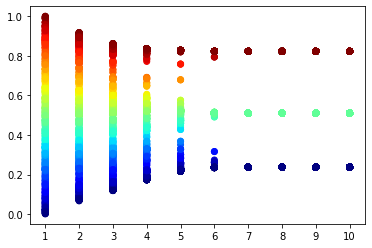

In [6]:
initial_agents = np.random.rand(625)
history = simulate(initial_agents, eps=0.15, num_iters=10)

for t, agents in enumerate(history):
    plt.scatter([t+1] * len(agents), agents, c=agents, cmap='jet')

        
plt.xticks(range(1, len(history) + 1))
plt.show()

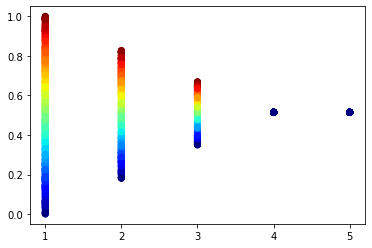

In [7]:
initial_agents = np.random.rand(625)
history = simulate_to_convergence(initial_agents, eps=0.35)

for t, agents in enumerate(history):
    plt.scatter([t+1] * len(agents), agents, c=agents, cmap='jet')

plt.xticks(range(1, len(history) + 1))
plt.show()

## Algorithm

In [22]:
# Finds the minimum epsilon / confidence bound that leads to a consensus convergence.
# Assumes agents are within the 0-to-1 range.
def find_min_eps_normalized(agents, target_clusters):
    high = 1.0
    low = 0.0
    num_iters = 0
    diffs = []
    while np.abs(low - high) >= 10**(-6):
        num_iters += 1
        diffs.append(
            (num_iters, np.abs(low - high))
        )
        mid = (high + low) / 2.0
        num_clusters = np.unique(simulate_to_convergence(agents, eps=mid)[-1]).shape[0]
        
        if num_clusters <= target_clusters:
            high = mid
        else:
            low = mid
            
    return low, high, diffs


    
def find_min_eps(agents, target_num_clusters):
    # First, we normalize the agents to the 0-to-1 range.
    max_agents = max(agents)
    agents_norm = np.array([elem / max_agents for elem in agents])
    assert max(agents_norm) <= 1.0
    
    # Find the solution confidence bound for the normalized agents.
    low_n, high_n, diffs = find_min_eps_normalized(agents_norm, target_num_clusters)
    low, high = max(agents) * low_n, max(agents) * high_n
    
    return low, high, diffs

### Test Algorithm

In [23]:
t1 = np.random.rand(10)
t2 = 100*np.random.rand(10)
mixed_agents = np.concatenate([t1, t2])

In [24]:
low_eps, high_eps, diffs = find_min_eps(mixed_agents, target_num_clusters=3)
print("Confidence bound leads to non-consensus convergence: ", low_eps)
print("Confidence bound leads to consensus convergence: ", high_eps)

Confidence bound leads to non-consensus convergence:  20.37982269176631
Confidence bound leads to consensus convergence:  20.379916987354978


### Graph Difference in Lower / Upper Bound vs. Iters

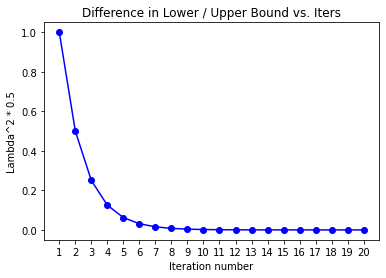

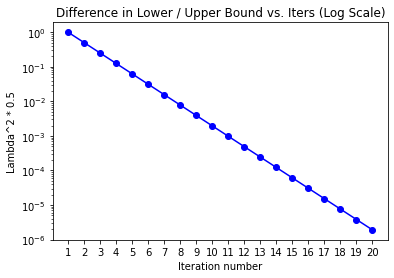

In [34]:
iters, diff_terms = list(zip(*diffs))

# Normal Plot.
plt.title("Difference in Lower / Upper Bound vs. Iters")
plt.plot(iters, diff_terms, color="blue", marker="o")
plt.xticks(iters)
plt.xlabel("Iteration number")
plt.ylabel("Lambda^2 * 0.5")
plt.show()

# Log-scale Plot.
plt.title("Difference in Lower / Upper Bound vs. Iters (Log Scale)")
plt.plot(iters, diff_terms, color="blue", marker="o")
plt.yscale('log')
plt.xticks(iters)
plt.xlabel("Iteration number")
plt.ylabel("Lambda^2 * 0.5")
plt.show()

### Test lower-bound confidence bound

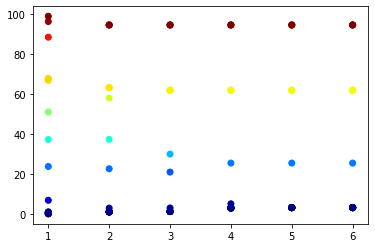

In [28]:
history = simulate_to_convergence(mixed_agents, eps=low_eps)
for t, agents in enumerate(history):
    plt.scatter([t+1] * len(agents), agents, c=agents, cmap='jet')
    
plt.xticks(range(1, len(history) + 1))
plt.show()

### Test upper-bound confidence bound

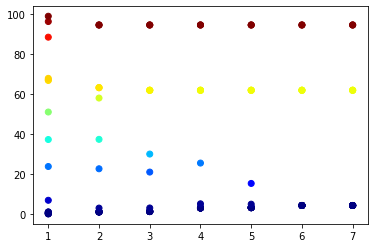

In [29]:
history = simulate_to_convergence(mixed_agents, high_eps)
for t, agents in enumerate(history):
    plt.scatter([t+1] * len(agents), agents, c=agents, cmap='jet')
        
plt.xticks(range(1, len(history) + 1))
plt.show()

## Simulations

### First set of simulations

In [41]:
target_clusters = [1, 2, 3]
lower_eps = []
upper_eps = []
simulations_history = []
diffs_history = []
agents = np.random.rand(626)

In [42]:
# We run the algorithm for each target number of clusters to find a strict lower bound & 
# inclusive upper bound on the minimum confidence bound necessary for the agents to 
# converge to the target number of clusters
for target in target_clusters:
    low_eps, high_eps, diffs = find_min_eps(agents, target_num_clusters=target)
    lower_eps.append(low_eps)
    upper_eps.append(high_eps)
    diffs_history.append(diffs)

In [43]:
# With each set of determined bounds, use both bounds and simulate the HK system with the agents
# to convergence and record the agent positions at each timestep.
low_eps_history_simulations = []
high_eps_history_simulations = []
for i in range(len(target_clusters)):
    low_eps = lower_eps[i]
    high_eps = upper_eps[i]
    
    low_history = simulate_to_convergence(agents, low_eps)
    high_history = simulate_to_convergence(agents, high_eps)
    
    low_eps_history_simulations.append(low_history)
    high_eps_history_simulations.append(high_history)

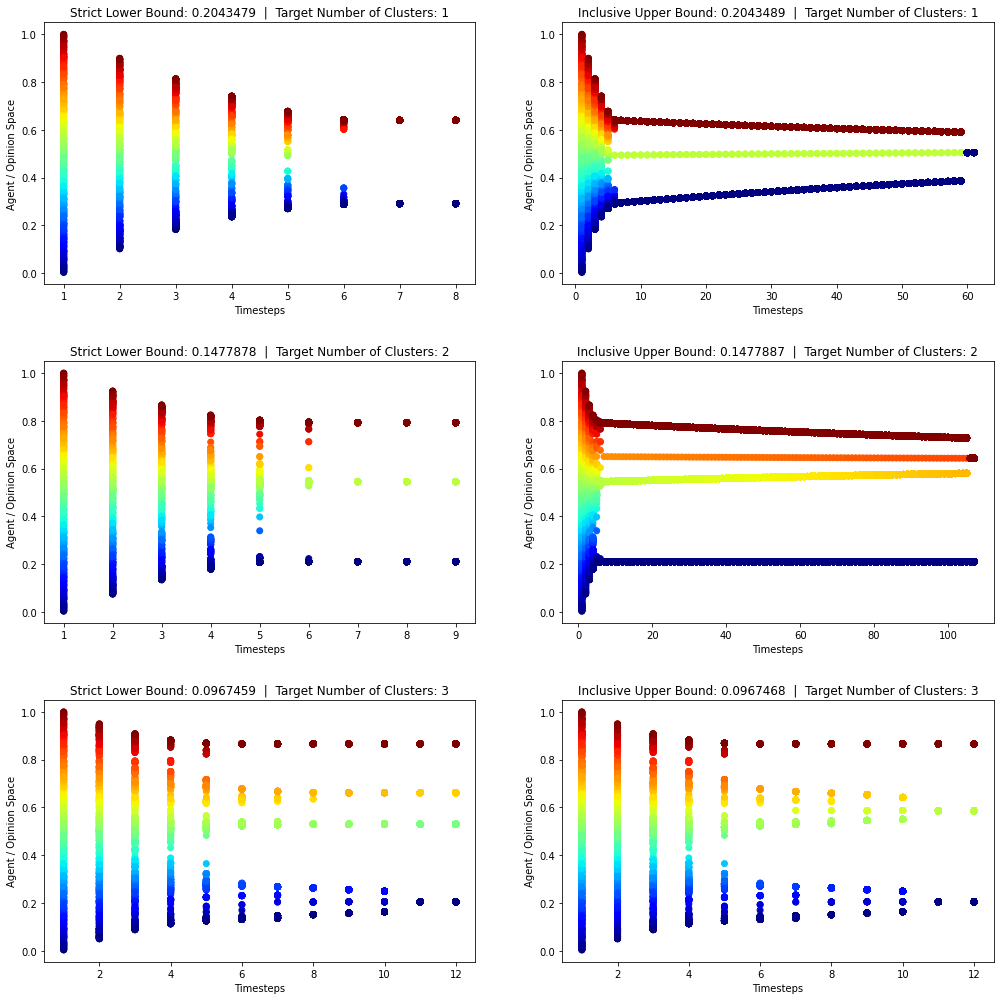

In [44]:
plt.figure(figsize=(14, 14))

subplot_index = [elem for elem in range(1, len(target_clusters) * 2 + 1, 2)]

for i, target in enumerate(target_clusters):
    low_history = low_eps_history_simulations[i]    
    low_eps = lower_eps[i]
    high_history = high_eps_history_simulations[i]
    high_eps = upper_eps[i]
    
    plt.subplot(3, 2, subplot_index[i])
    for t, agents_h in enumerate(low_history):
        plt.scatter([t+1] * len(agents_h), agents_h, c=agents_h, cmap='jet')
        plt.ylabel("Agent / Opinion Space")
        plt.xlabel("Timesteps")
        plt.title(f"Strict Lower Bound: {round(low_eps, 7)}  |  Target Number of Clusters: {target}")
    
    plt.subplot(3, 2, subplot_index[i] + 1)
    for t, agents_h in enumerate(high_history):
        plt.scatter([t+1] * len(agents_h), agents_h, c=agents_h, cmap='jet')
        plt.ylabel("Agent / Opinion Space")
        plt.xlabel("Timesteps")
        plt.title(f"Inclusive Upper Bound: {round(high_eps, 7)}  |  Target Number of Clusters: {target}")
       
plt.tight_layout(h_pad=3, w_pad=5)
plt.show()

### Convergence Plot

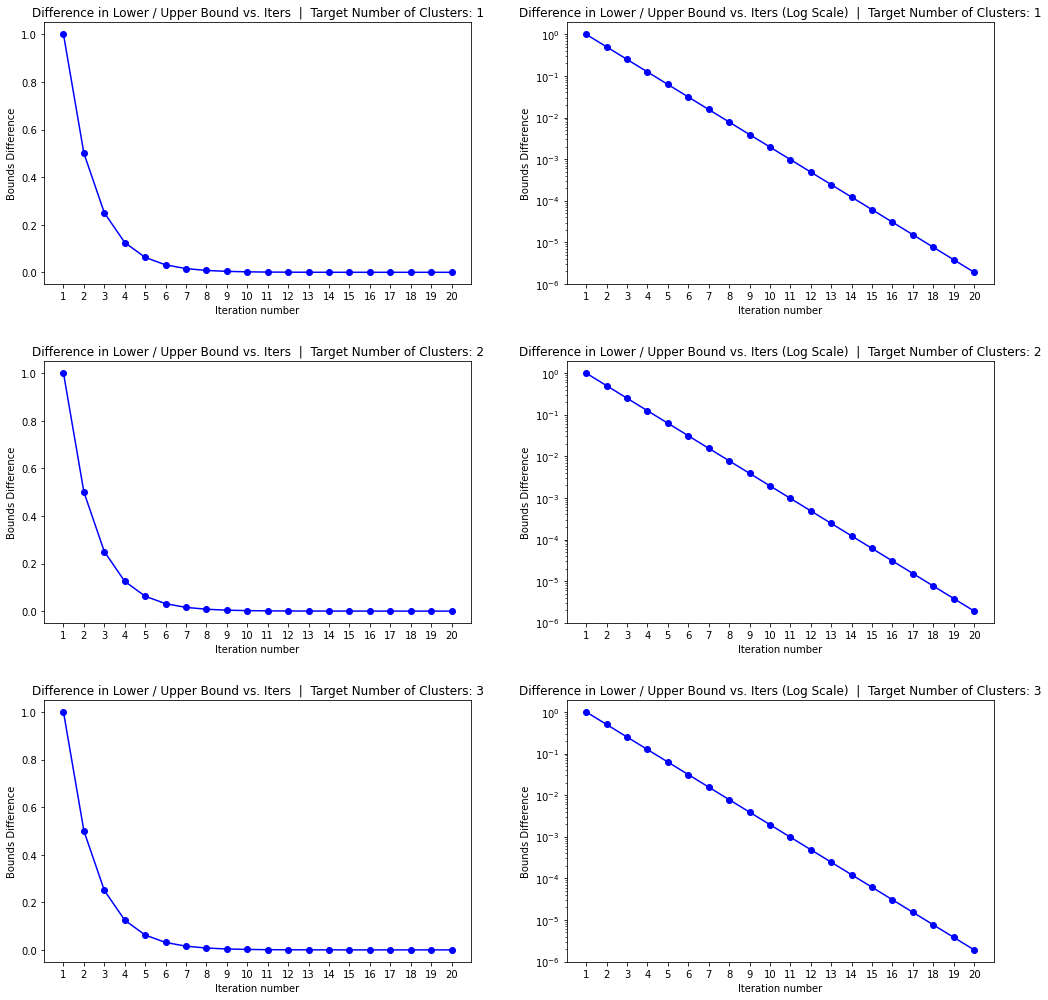

In [48]:
plt.figure(figsize=(14, 14))
subplot_index = [elem for elem in range(1, len(target_clusters) * 2 + 1, 2)]
for i, diff_history in enumerate(diffs_history):
    iters, diff_terms = list(zip(*diff_history))
    
    # Normal Plot.
    plt.subplot(3, 2, subplot_index[i])
    plt.title(f"Difference in Lower / Upper Bound vs. Iters  |  Target Number of Clusters: {i + 1}")
    plt.plot(iters, diff_terms, color="blue", marker="o")
    plt.xticks(iters)
    plt.xlabel("Iteration number")
    plt.ylabel("Bounds Difference")
    
    # Log-scale Plot.
    plt.subplot(3, 2, subplot_index[i] + 1)
    plt.title(f"Difference in Lower / Upper Bound vs. Iters (Log Scale)  |  Target Number of Clusters: {i + 1}")
    plt.plot(iters, diff_terms, color="blue", marker="o")
    plt.yscale('log')
    plt.xticks(iters)
    plt.xlabel("Iteration number")
    plt.ylabel("Bounds Difference")
       
plt.tight_layout(h_pad=3, w_pad=5)
plt.show()

### Second Set of Simulations

In [89]:
target_clusters = [1, 2, 3]
lower_eps = []
upper_eps = []
simulations_history = []
diffs_history = []

agents_01 = np.random.rand(323)
agents_100 = 100 * np.random.rand(323)
agents = np.concatenate([agents_01, agents_100])

In [90]:
# We run the algorithm for each target number of clusters to find a strict lower bound & 
# inclusive upper bound on the minimum confidence bound necessary for the agents to 
# converge to the target number of clusters
for target in target_clusters:
    low_eps, high_eps, diffs = find_min_eps(agents, target_num_clusters=target)
    lower_eps.append(low_eps)
    upper_eps.append(high_eps)
    diffs_history.append(diffs)

In [91]:
# With each set of determined bounds, use both bounds and simulate the HK system with the agents
# to convergence and record the agent positions at each timestep.
low_eps_history_simulations = []
high_eps_history_simulations = []
for i in range(len(target_clusters)):
    low_eps = lower_eps[i]
    high_eps = upper_eps[i]
    
    low_history = simulate_to_convergence(agents, low_eps)
    high_history = simulate_to_convergence(agents, high_eps)
    
    low_eps_history_simulations.append(low_history)
    high_eps_history_simulations.append(high_history)

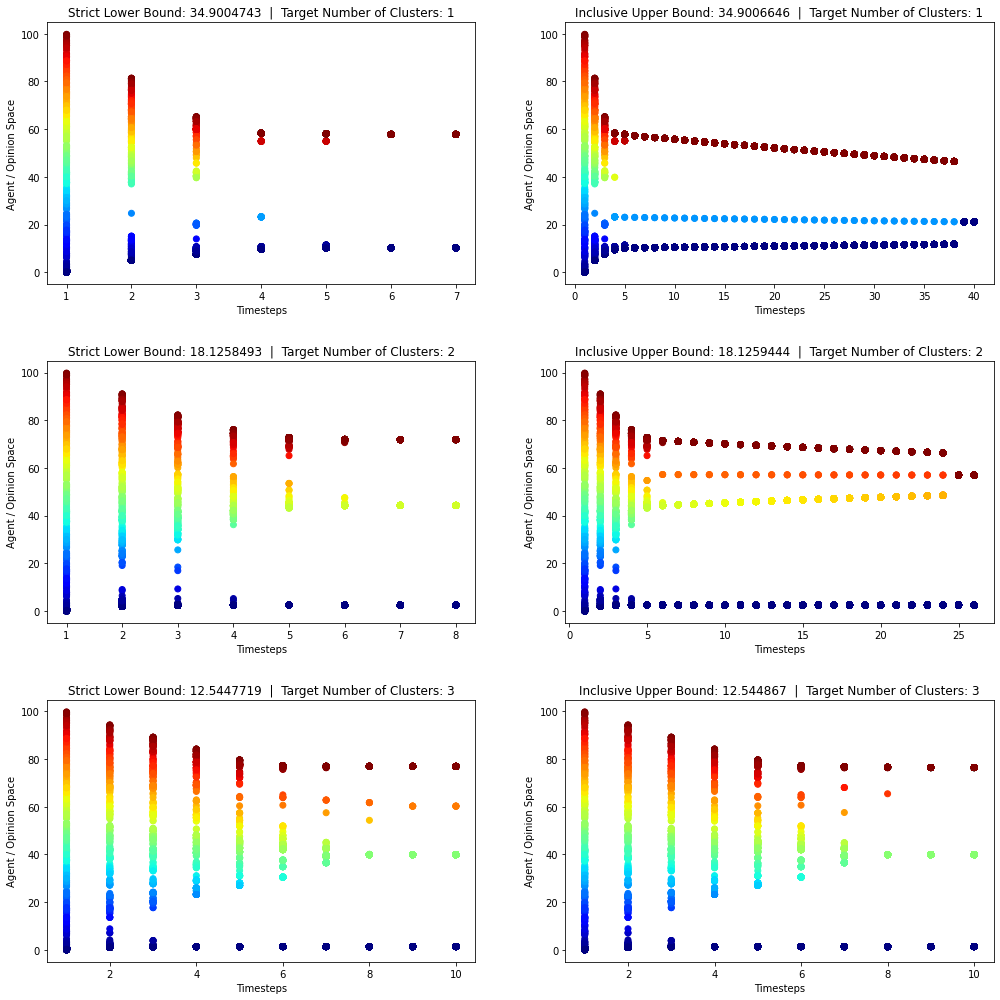

In [92]:
plt.figure(figsize=(14, 14))

subplot_index = [elem for elem in range(1, len(target_clusters) * 2 + 1, 2)]

for i, target in enumerate(target_clusters):
    low_history = low_eps_history_simulations[i]    
    low_eps = lower_eps[i]
    high_history = high_eps_history_simulations[i]
    high_eps = upper_eps[i]
    
    plt.subplot(3, 2, subplot_index[i])
    for t, agents_h in enumerate(low_history):
        plt.scatter([t+1] * len(agents_h), agents_h, c=agents_h, cmap='jet')
        plt.ylabel("Agent / Opinion Space")
        plt.xlabel("Timesteps")
        plt.title(f"Strict Lower Bound: {round(low_eps, 7)}  |  Target Number of Clusters: {target}")
    
    plt.subplot(3, 2, subplot_index[i] + 1)
    for t, agents_h in enumerate(high_history):
        plt.scatter([t+1] * len(agents_h), agents_h, c=agents_h, cmap='jet')
        plt.ylabel("Agent / Opinion Space")
        plt.xlabel("Timesteps")
        plt.title(f"Inclusive Upper Bound: {round(high_eps, 7)}  |  Target Number of Clusters: {target}")
       
plt.tight_layout(h_pad=3, w_pad=5)
plt.show()

### Third Set of Simulations

In [100]:
set_of_agents = [np.random.rand(100) for _ in range(100)]
target_clusters = [1, 2, 3]

In [102]:
low_eps = { 1: [], 2: [], 3:[] }
high_eps = { 1: [], 2: [], 3:[] }

for agents_i in set_of_agents:
    for target in target_clusters:
        low_eps_i, high_eps_i = find_min_eps(agents_i, target_num_clusters=target)
        low_eps[target].append(low_eps_i)
        high_eps[target].append(high_eps_i)

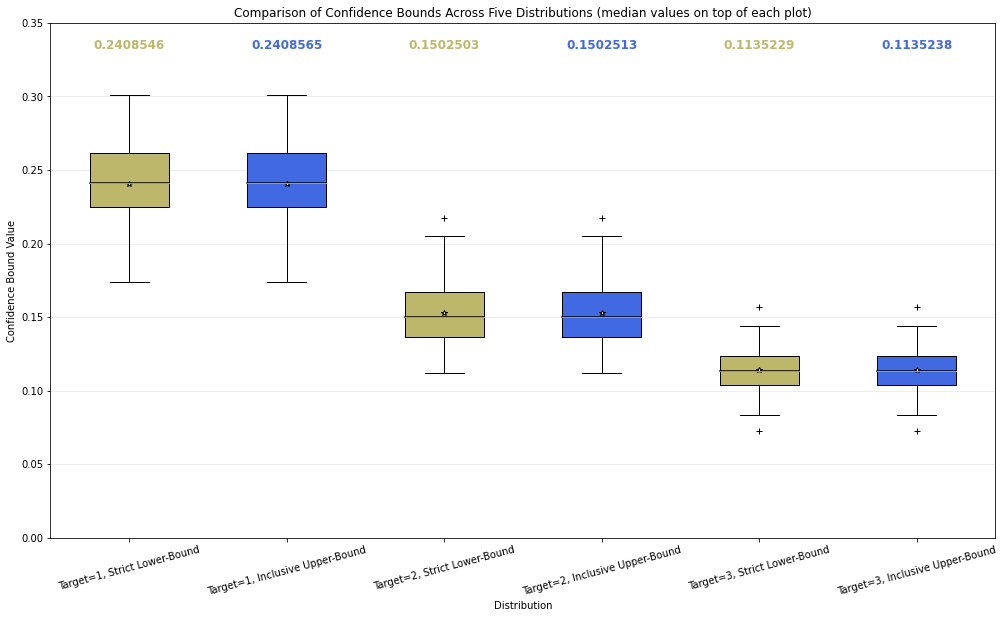

In [131]:
simulation_labels = [
    'Target=1, Strict Lower-Bound', 'Target=1, Inclusive Upper-Bound', 
    'Target=2, Strict Lower-Bound', 'Target=2, Inclusive Upper-Bound',
    'Target=3, Strict Lower-Bound', 'Target=3, Inclusive Upper-Bound'
]

data = [
    low_eps[1], high_eps[1],
    low_eps[2], high_eps[2],
    low_eps[3], high_eps[3],
]

fig, ax1 = plt.subplots(figsize=(15, 11))
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,
    title='Comparison of Confidence Bounds Across Five Distributions (median values on top of each plot)',
    xlabel='Distribution',
    ylabel='Confidence Bound Value',
)

box_colors = ['darkkhaki', 'royalblue']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    box_x = []
    box_y = []
    for j in range(5):
        box_x.append(box.get_xdata()[j])
        box_y.append(box.get_ydata()[j])
    box_coords = np.column_stack([box_x, box_y])

    ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
    
    med = bp['medians'][i]
    median_x = []
    median_y = []
    for j in range(2):
        median_x.append(med.get_xdata()[j])
        median_y.append(med.get_ydata()[j])
        ax1.plot(median_x, median_y, 'k')
    medians[i] = median_y[0]
    ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
             color='w', marker='*', markeredgecolor='k')

# Set the range + labels of the axes.
ax1.set_ylim(0.0, 0.35)
ax1.set_xticklabels(simulation_labels,
                    rotation=15, fontsize=10)

# Plot median values.
pos = np.arange(num_boxes) + 1
upper_labels = [str(round(s, 7)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(
        pos[tick], 
        .95, 
        upper_labels[tick],
        transform=ax1.get_xaxis_transform(),
        horizontalalignment='center', size='large',
        weight=weights[k], 
        color=box_colors[k]
    )


plt.show()